In [1]:
import os
import sys
import time

import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from scipy.ndimage.interpolation import rotate as sc_rotate
from torchvision import datasets, transforms
from scipy.optimize import curve_fit, least_squares, minimize

from pandas import read_fwf, DataFrame

In [2]:
from radioreader import *
from methods import *
from kittler import kittler_float

from InterpretableAE import *

### Load Data

In [3]:
directory = 'lrg'
ext = 'fits'
names = glob.glob('{0}/*.{1}*'.format(directory, ext))
images = []
for n in tqdm(range(len(names[:10]))):
    im = readImg(names[n], normalize=True, sz=128)
    k = kittler_float(im, copy=False)
    images.append( np.expand_dims(k, axis=0) )
    del im
    del k
print("Number of images", len(images))
im_tensor = torch.tensor(images)


Number of images 10


### Network Params

In [4]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(1)
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

#arguments
batch_size = 64
test_batch_size = 64

ts = list(im_tensor.shape)
imh, imw = ts[2], ts[3]
print(im_tensor.shape)
print('imh, imw = ',imh, imw)

epochs = 15
learning_rate = 0.001
momentum = 0.9 # 'SGD momentum'
latent_space=16

cpu
torch.Size([10, 1, 128, 128])
imh, imw =  128 128


In [6]:
model = InterpretableAE(imh, imw, device, latent_dim=64).to(device)
train_loader = torch.utils.data.DataLoader(im_tensor, batch_size=batch_size, shuffle=True)

In [7]:
model.load_state_dict(torch.load('unlrg_linear_model_mcr', map_location=torch.device('cpu')))
print(model.eval())

InterpretableAE(
  (down1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (down3): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (latentd): Linear(in_features=4096, out_features=64, bias=True)
  (latentu): Linear(in_features=64, out_features=4096, bias=True)
  (up3): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (up1): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)


In [8]:
def get_rot_data(n_rot, data):
    data = torch.from_numpy(data)
    with torch.no_grad():
        angles = torch.linspace(0, 2*np.pi, steps=n_rot)
        angles = angles.view(n_rot, 1)

        data = data.view(data.size(0), -1)
        data = data.repeat(n_rot, 1)
        data = data.view(-1, 1, imh, imw).to(device, dtype=torch.float)

        output = model.encode(data, angles)
        output = output.cpu().numpy()
    return output

### Labeld Radio Galaxies

In [9]:
lrg = read_fwf('catalog/mrt-table3.txt', skiprows=41, header=None)
labeled = DataFrame({'Name':lrg[0], 'Label':lrg[7]})

In [10]:
n_tyepes = 6
names = [[]] * n_tyepes
for i in range(n_tyepes):
    l1 = labeled['Label'] == str(i + 1)
    names[i] = labeled[l1]['Name'].tolist()

In [11]:
directory = 'lrg'
ext = 'fits'

images_s = []

for i in tqdm(range(n_tyepes)):
    images = []
    for name in names[i][:20]:
        f_name = '{0}/{1}.{2}'.format(directory, 
                                      name.replace('.','_'), ext)
        im = readImg(f_name, normalize=True, sz=128)
        k = kittler_float(im, copy=False)
        images.append(k)
    images_s.append(np.array(images))

In [24]:
n_rot = 32
o_np = get_rot_data(32, images_s[3][0:1])

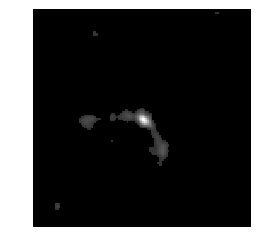

In [16]:
plt.imshow(images_s[3][0], cmap='gray')
plt.axis('off')
plt.show()

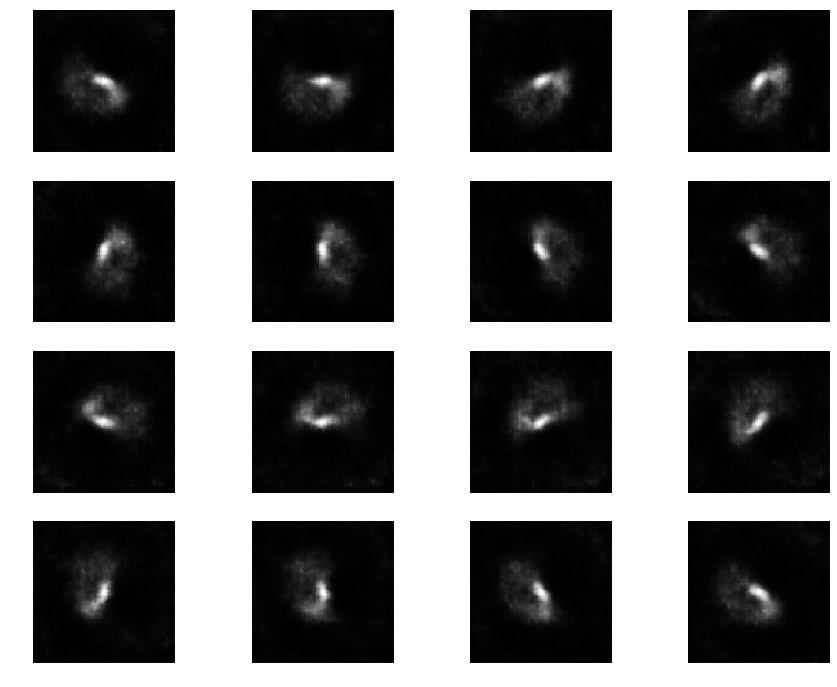

In [21]:
with torch.no_grad():
    dec = model.decode(torch.from_numpy(o_np).to(device))
    dec = dec.cpu().view(-1,1,imh,imw)
d_np = dec.numpy()

f, ax = plt.subplots(4, 4, figsize=(15, 12))
for i in range(4): 
    for j in range(4):
        ax[i][j].imshow(d_np[2*(i*4 + j),0]**0.5, cmap='gray')
        ax[i][j].axis('off')

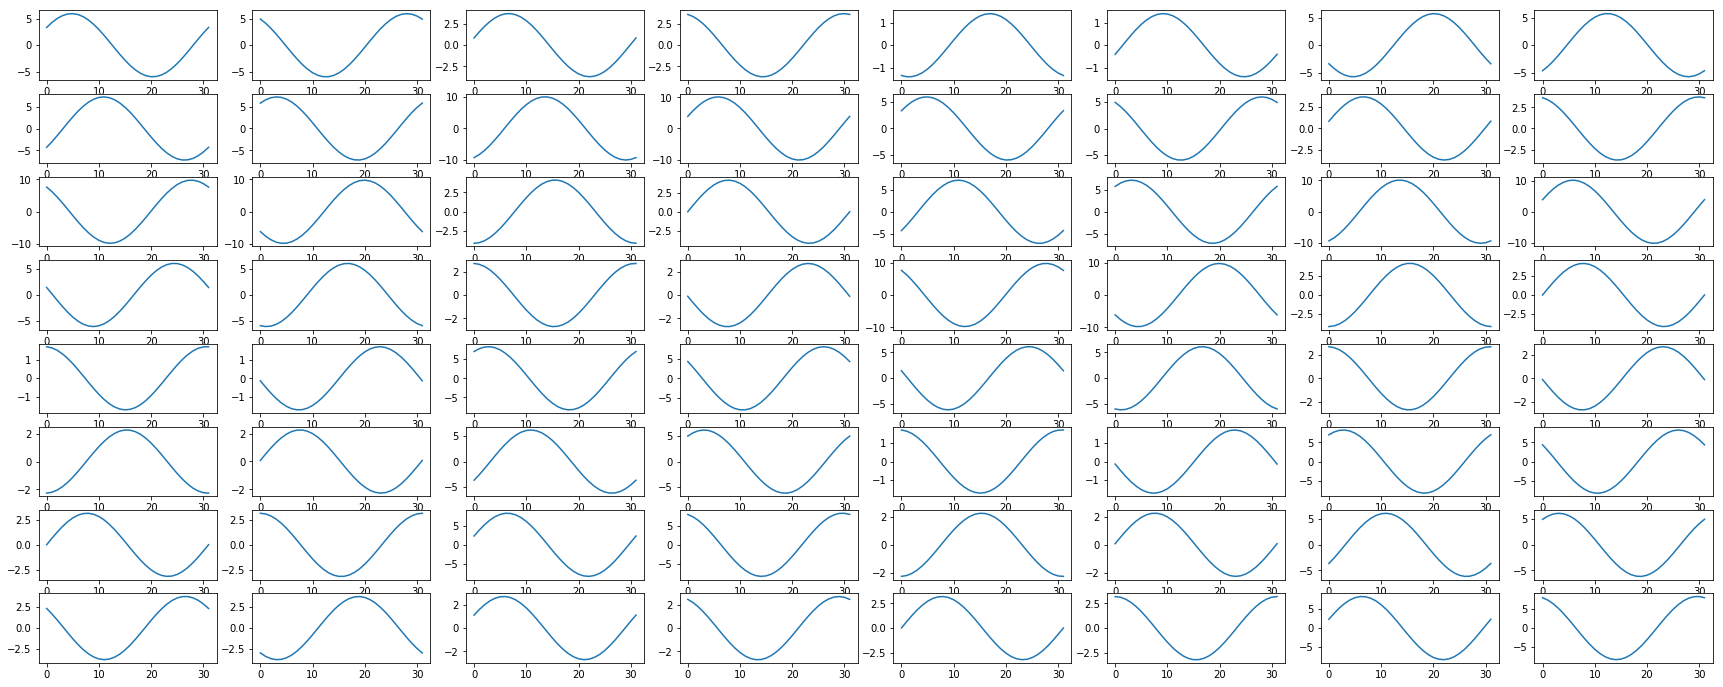

In [22]:
f, ax = plt.subplots(8, 8, figsize=(30, 12))
for i in range(8): 
    for j in range(8):
        ax[i][j].plot(o_np[:,-i*4 + j])

In [25]:
def sin_func(x, a=1, c=0):
    return a * np.sin(x + c*np.pi / 180)
x_data = np.linspace(0, 2 * np.pi, n_rot)

In [54]:
def get_fit(data_array, use_tqdm=True):
    fits_l = []
    range_iter = tqdm(range(data_array.shape[1])) if use_tqdm else range(data_array.shape[1])
    for i in range_iter:
        y_dt = data_array[:, i]
        fit = curve_fit(sin_func, x_data, y_dt, bounds=(0,[np.inf, 360]))[0]
        fits_l.append(fit)
    return np.array(fits_l)

def get_val_generator(fit):
    def gen(v):
        vals = np.zeros((fit.shape[0]))
        for i in range(len(vals)):
            vals[i] = sin_func(v, *fit[i])
        return vals
    return gen

def get_decoded_image(code, model):
    with torch.no_grad():
        dt  = torch.from_numpy(code)
        dec = model.decode(dt.to(device, dtype=torch.float))
        dec = dec.cpu().view(-1,1,imh,imw)
    d_np = dec.numpy()
    return d_np[0,0]

In [56]:
fits = get_fit(o_np, True)

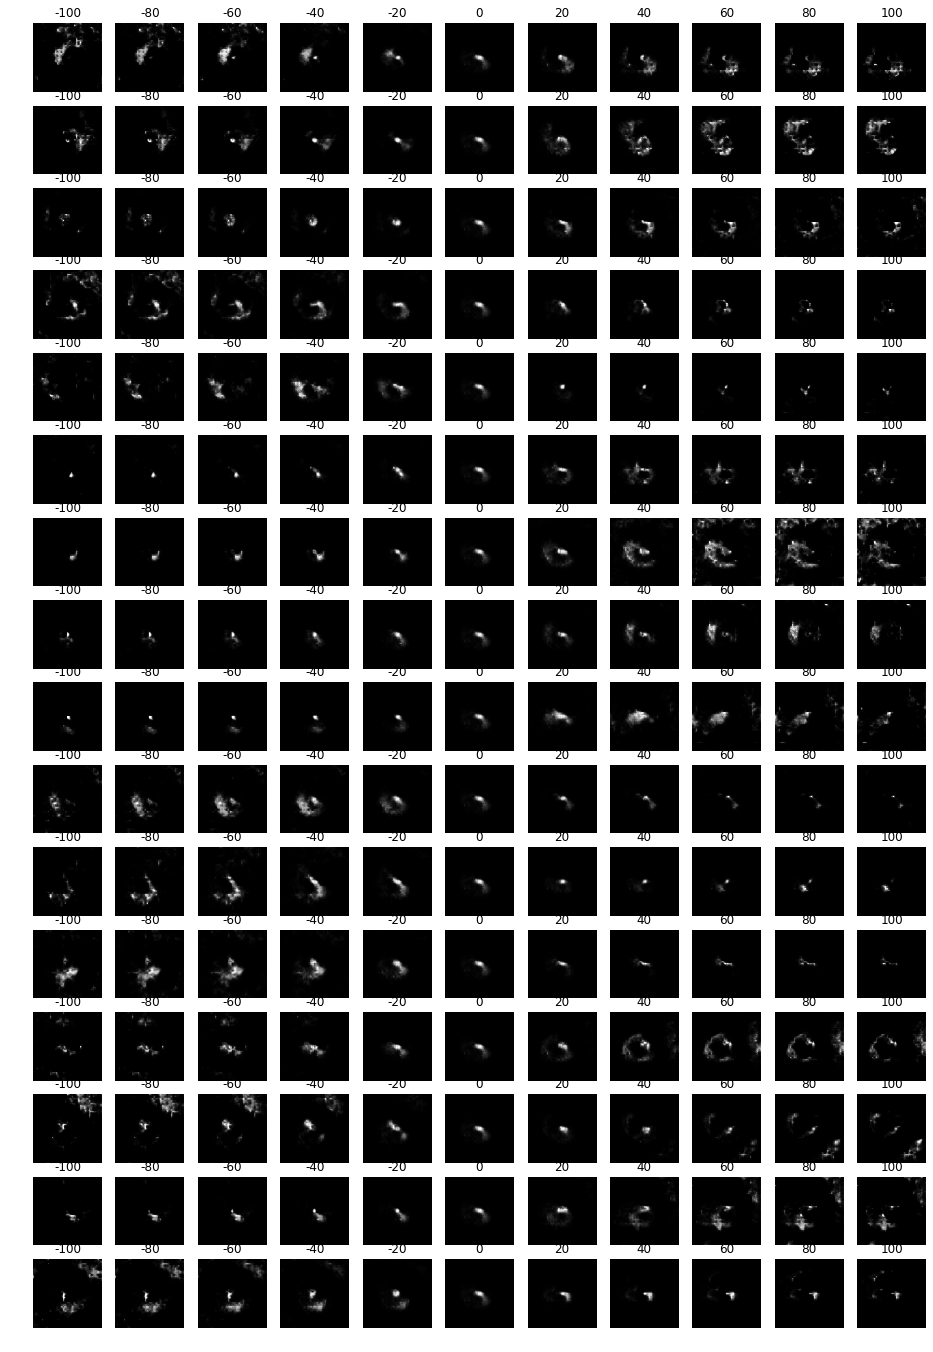

In [36]:
gen = get_val_generator(fits)
f, ax = plt.subplots(16, 11, figsize=(16, 24))
for i in range(16): 
    for j in range(11):
        g = gen(0)
        v = 20*(j - 5)
        g[i] = g[i] + v
        d_m = get_decoded_image(g, model)
        ax[i][j].imshow(d_m, cmap='gray')
        ax[i][j].axis('off')
        ax[i][j].set_title(v)

In [97]:
fits_20 = []
rg_type = 3
for z, img in enumerate(tqdm(images_s[rg_type][:20])):
    o_np = get_rot_data(32, np.expand_dims(img, 0))
    fits_20.append(get_fit(o_np, False))
fits_20 = np.array(fits_20)
# print(fits_20.shape)

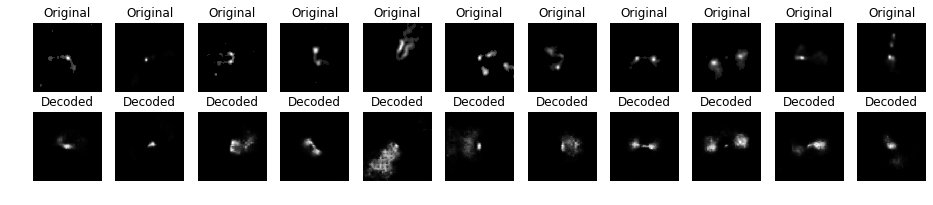

In [98]:
f, ax = plt.subplots(2, 11, figsize=(16, 3))
for j in range(11):
    fi = fits_20[j]
    fi[:, 1] -= np.average(fi[:, 1])
    gen = get_val_generator(fi)
    g = gen(0)
    d_m = get_decoded_image(g, model)
    
    ax[0][j].imshow(images_s[rg_type][j], cmap='gray')
    ax[0][j].axis('off')
    ax[0][j].set_title('Original')
    
    ax[1][j].imshow(d_m, cmap='gray')
    ax[1][j].axis('off')
    ax[1][j].set_title('Decoded')

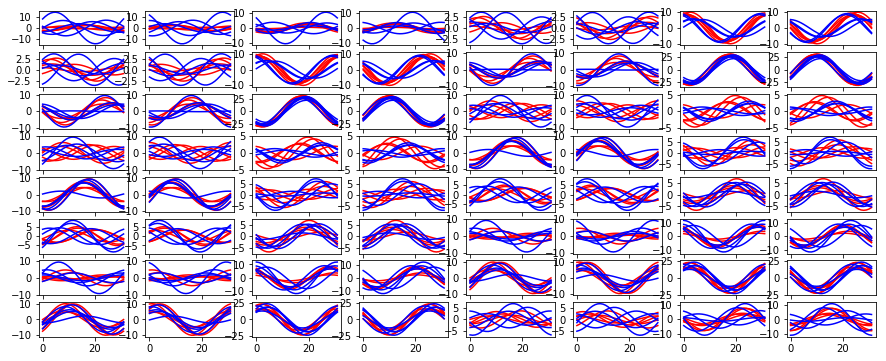

In [95]:
f, ax = plt.subplots(8, 8, figsize=(15, 6))
for fi in fits_20[:5]:
    fi[:, 1] -= np.average(fi[:, 1])
    for i in range(8): 
        for j in range(8):
            ax[i][j].plot(sin_func(x_data, *fi[i*4 + j]), c='r')
#             ax[i][j].plot(sin_func(x_data, fi[i*4 + j][0], 0))
for fi in fits_20_2[:5]:
    fi[:, 1] -= np.average(fi[:, 1])
    for i in range(8): 
        for j in range(8):
            ax[i][j].plot(sin_func(x_data, *fi[i*4 + j]), c='b')